## Importations

In [ ]:
## plots
import matplotlib.pyplot as plt
from matplotlib import rc

##
import seaborn as sns
import numpy as np
import pandas as pd

import sys
sys.path.append('../')

## ML :
from scripts.machine_learning_utils import *
from scripts.models import *
from scripts.descriptors import *
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

rc('font', family='sans-serif', size = 7)
rc('figure', dpi= 700)
rc(('xtick', 'ytick'), labelsize = 7)
rc('legend', fontsize=6)
rc('lines', linewidth = 1)
rc('axes', linewidth = 0.5, labelsize =8)
rc('legend', handlelength = 2)




## Load data

In [2]:
df_total = pd.read_csv('../tables/data/df_total.csv').set_index('SMILES')

df_OCO = df_total[df_total.group == 'OCO']
df_ONO = df_total[df_total.group == 'ONO']
df_NNN = df_total[df_total.group == 'NNN']
df_triarylboranes = df_total[df_total.group == "triarylboranes"]

In [11]:
def df(S):
    if S == 'ONO':
        return df_ONO
    if S == 'NNN':
        return df_NNN
    if S == 'OCO':
        return df_OCO
    if S == 'triarylboranes':
        return df_triarylboranes


## Create dataframe

In [125]:
S = 'ONO' #choose the molecular structure/scaffold

X = create_descriptors(df(S).index, 'hammett', structure = S)


In [126]:
FIA = df(S).FIA

In [127]:
df_X = pd.DataFrame(data = X, columns = get_names('hammett'))

### Classify Lewis acids based on their FIA value


<Axes: xlabel='FIA', ylabel='Density'>

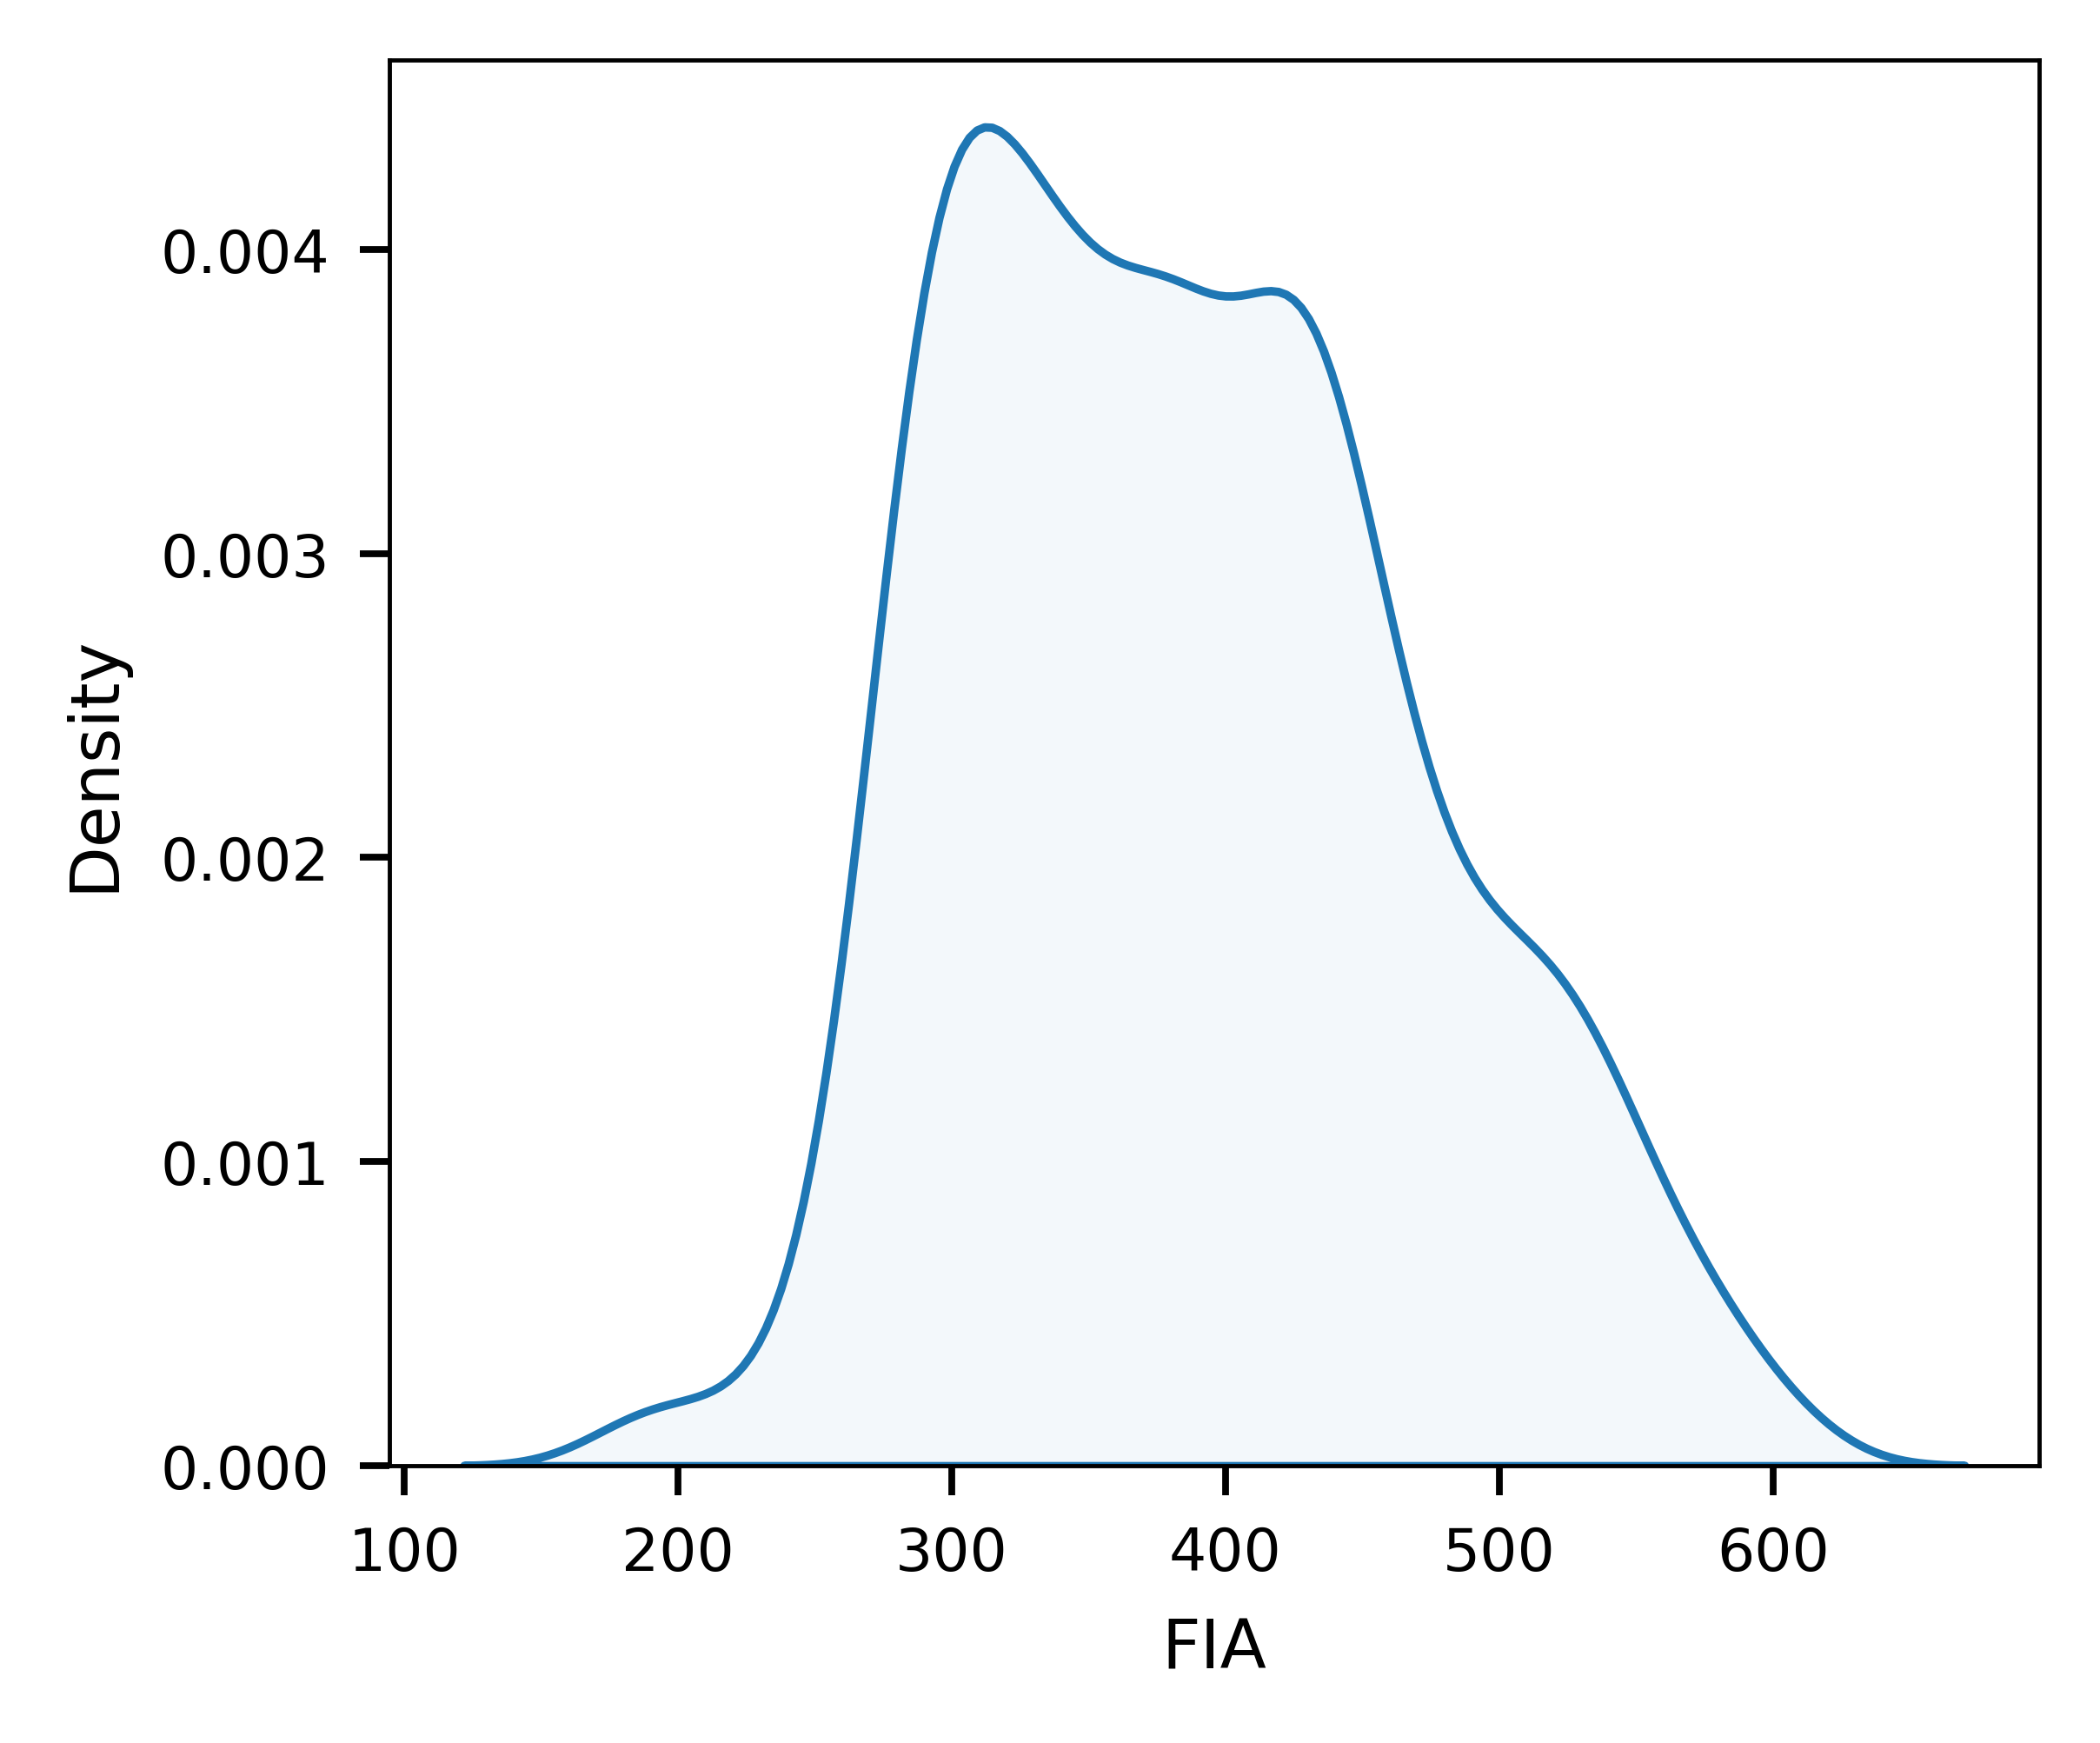

In [71]:
fig = plt.figure(figsize=(3.5, 3))
bandwidth = 0.7
sns.kdeplot(df(S), x="FIA", 
            bw_adjust = bandwidth, label = 'all ONO',
            fill =True, alpha=0.05)

Based on FIA distribution, we can define classes of FIA. Actually the classes can be defined based on the distribution for all molecular structures.

In [9]:
def classify_FIA(FIA):
    if FIA < 250 :
        return('very weak LA')
    if 250 <= FIA < 300:
        return('weak LA')
    if 300<=FIA <400 :
        return('medium LA')
    if 400 <= FIA < 500 :
        return('good LA')
    if 500 <= FIA < 550: 
        return('strong LA')
    if 550 <= FIA:
        return('super LA')

In [130]:
classes = [classify_FIA(fia) for fia in FIA]

### Create and interpret decision tree model with selected features

##### Build model

In [128]:
selected_features = [  'NBO=O,o', 'NBO=O,m', 'NBO=O,p', 'Lo']

In [129]:
df_X_selec = df_X.loc[:,selected_features]
X_selec = np.array(df_X_selec)

In [131]:
def evaluate_tree(X,Y, n_rep =10):
    clf = DecisionTreeClassifier(max_depth=3,random_state=1, criterion = 'entropy')
    cv = RepeatedKFold(n_splits=10, n_repeats=n_rep)
    scores = cross_val_score(clf, X, Y, cv=cv, n_jobs=-1)
    return(scores)

In [132]:
scores = evaluate_tree(X_selec, classes, n_rep = 10)
accuracy = np.mean(scores)
print('accuracy:', accuracy)

accuracy: 0.7331746031746033


In [133]:
clf = DecisionTreeClassifier(max_depth=3,random_state=1, criterion = 'entropy')
clf.fit(X_selec, classes)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=1)

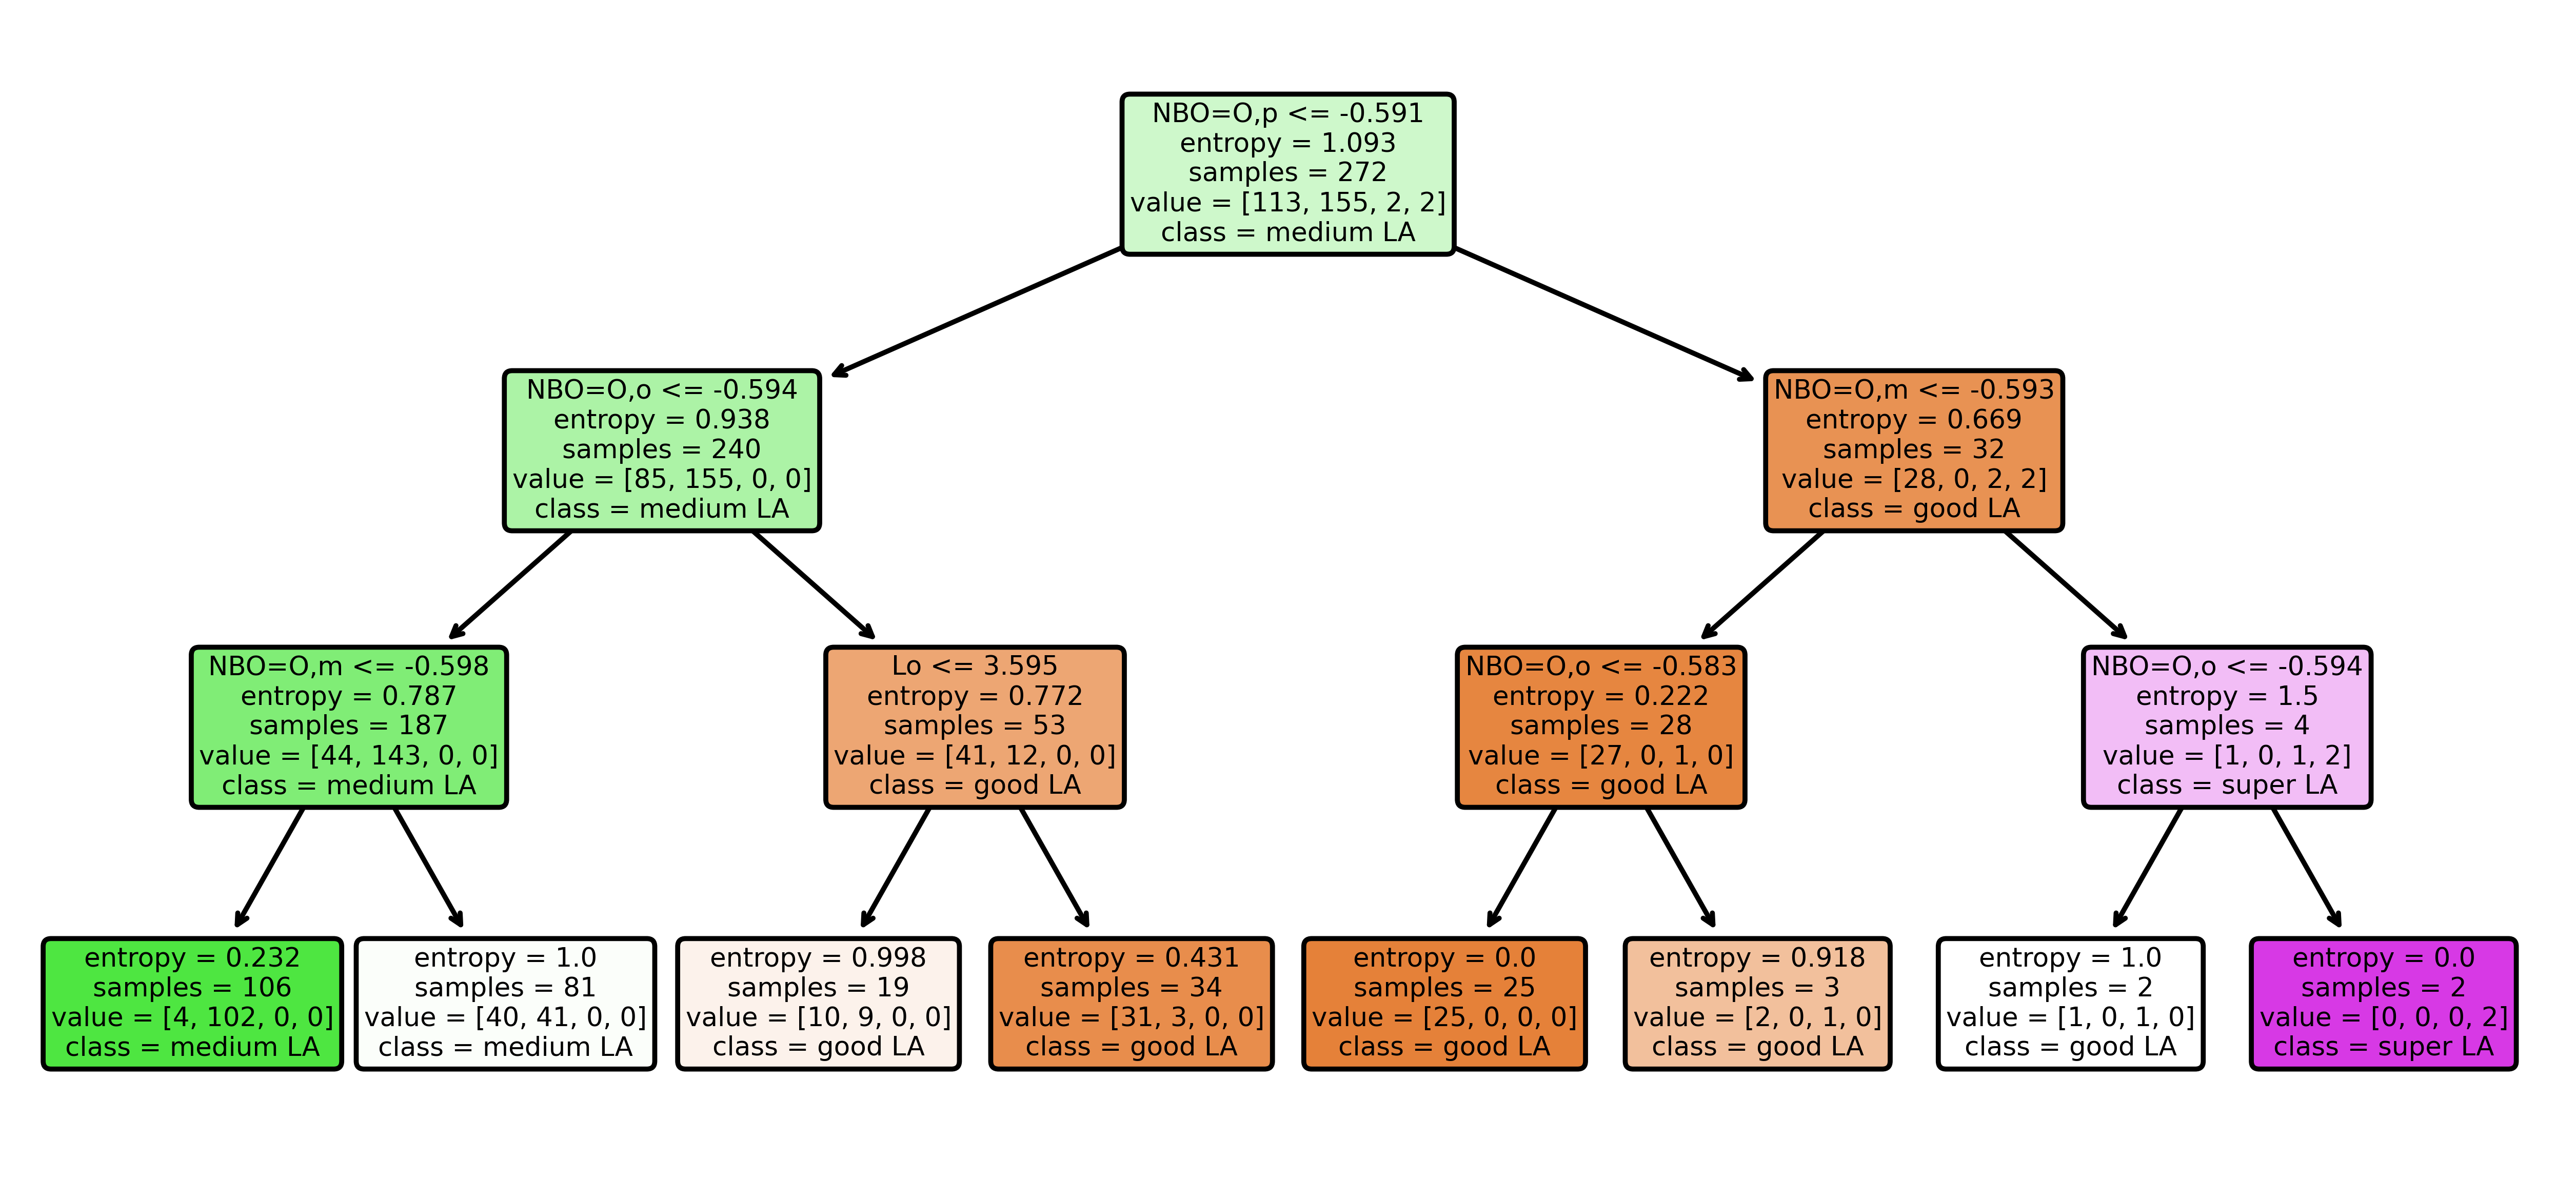

In [134]:
fig = plt.figure(figsize = (9,4))

tree.plot_tree(clf, feature_names = selected_features, proportion = False, class_names =clf.classes_,  rounded = True, fontsize = 5.3, filled = True)
plt.show()

fig.savefig('../results/interpretability/hammett_descriptors/ONO_hammett_selected_tree', transparent= True, facecolor='white', bbox_inches='tight')

In [135]:
tree_as_text = tree.export_text(clf, feature_names=selected_features)
print(tree_as_text)

|--- NBO=O,p <= -0.59
|   |--- NBO=O,o <= -0.59
|   |   |--- NBO=O,m <= -0.60
|   |   |   |--- class: medium LA
|   |   |--- NBO=O,m >  -0.60
|   |   |   |--- class: medium LA
|   |--- NBO=O,o >  -0.59
|   |   |--- Lo <= 3.59
|   |   |   |--- class: good LA
|   |   |--- Lo >  3.59
|   |   |   |--- class: good LA
|--- NBO=O,p >  -0.59
|   |--- NBO=O,m <= -0.59
|   |   |--- NBO=O,o <= -0.58
|   |   |   |--- class: good LA
|   |   |--- NBO=O,o >  -0.58
|   |   |   |--- class: good LA
|   |--- NBO=O,m >  -0.59
|   |   |--- NBO=O,o <= -0.59
|   |   |   |--- class: good LA
|   |   |--- NBO=O,o >  -0.59
|   |   |   |--- class: super LA



In [ ]:
df_feature = pd.DataFrame()

importances = clf.feature_importances_

df_feature['name']=list(selected_features)
df_feature['importance']=list(importances)
more_important_features = list(df_feature.sort_values('importance', ascending = False).head(11).name)

In [ ]:
more_important_features

['NBO=O,p', 'NBO=O,m', 'NBO=O,o', 'Lo']

## Triarylboranes

Get data

In [95]:
X = create_descriptors(df_triarylboranes.index, 'hammett', structure = 'triarylboranes')

In [96]:
FIA = df_triarylboranes.FIA


In [97]:
df_X = pd.DataFrame(data = X, columns = get_names('hammett'))

In [98]:
classes = [classify_FIA(fia) for fia in FIA]

In [111]:
selected_features = [  'NBO=O,p', 'NBO=O,o', 'NBO=O,m','Lo', 'θtor']

In [116]:
selected_features = [  'σm','σp',  'θtor']

In [117]:
df_X_selec = df_X.loc[:,selected_features]
X_selec = np.array(df_X_selec)

In [118]:
scores = evaluate_tree(X_selec, classes, n_rep = 10)
accuracy = np.mean(scores)
print('accuracy:', accuracy)

accuracy: 0.4923391812865498


In [120]:
clf = DecisionTreeClassifier(max_depth=3,random_state=1, criterion = 'entropy')
clf.fit(X_selec, classes)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=1)

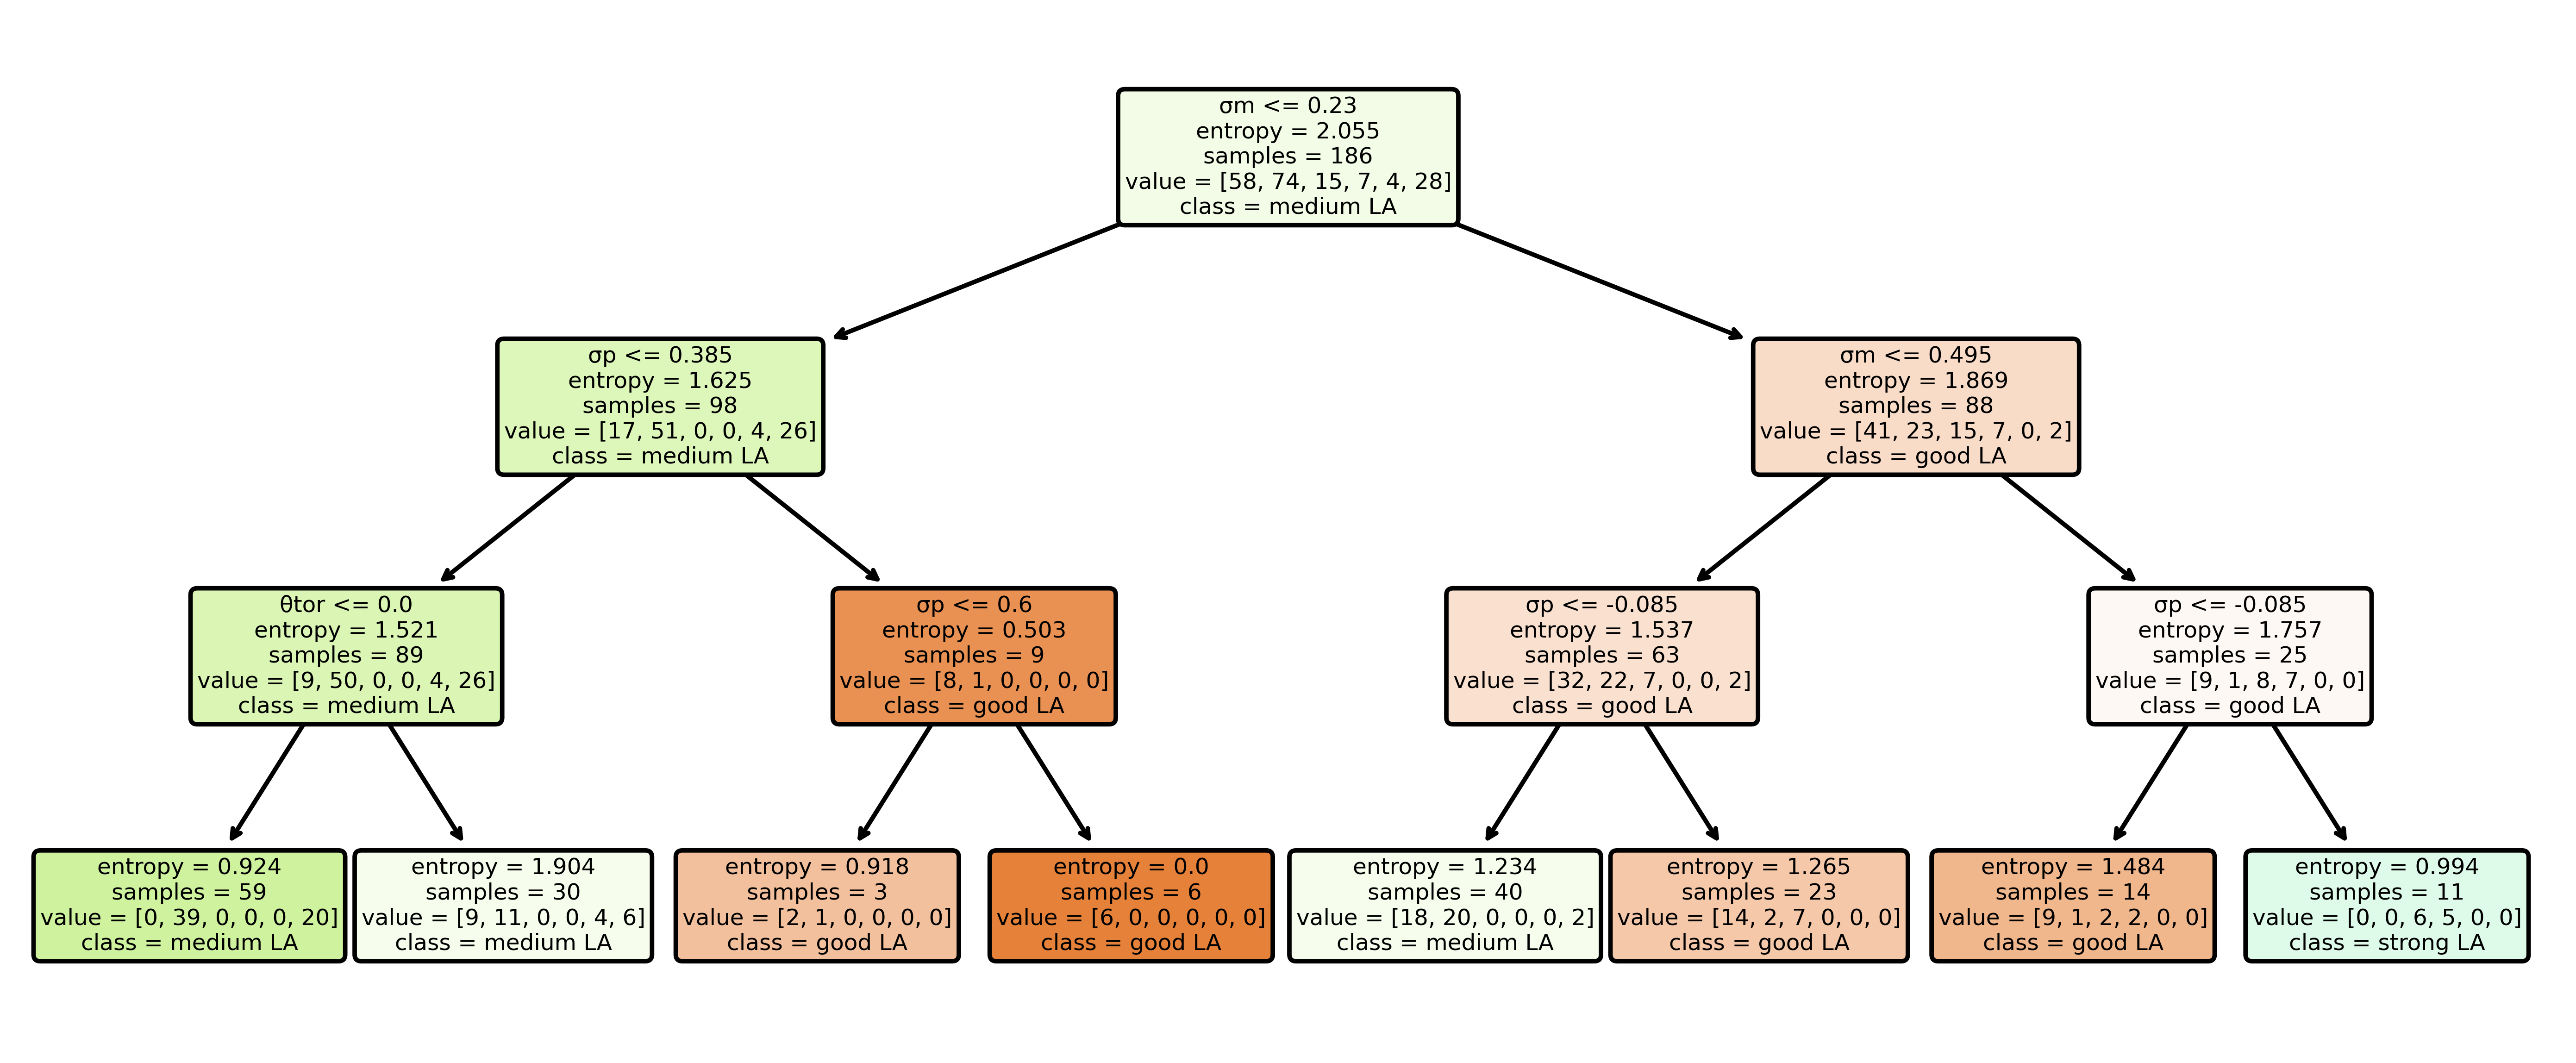

In [123]:
fig = plt.figure(figsize = (10,4))

tree.plot_tree(clf, feature_names = selected_features, proportion = False, class_names =clf.classes_, rounded = True, fontsize = 5,filled = True)
plt.show()

fig.savefig('../results/interpretability/hammett_descriptors/triarylboranes_hammett_selected_tree', transparent= True, facecolor='white', bbox_inches='tight')